In [1]:
from itertools import combinations

import numpy as np
import numpy.typing as npt
import open3d as o3d
import open3d.core as o3c

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

from typing import List

from spectra import Spectra
from models import gaussian
from metamers import Cone, Observer

from scipy.spatial.distance import cdist

ModuleNotFoundError: No module named 'open3d'

**Load Cone Data**

In [2]:
def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr


In [24]:
cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')

l_cone = Cone(cone_data[:, [0, 1]])
m_cone = Cone(cone_data[:, [0, 2]])
s_cone = Cone(remove_trailing_nans(cone_data[:, [0, 3]]))

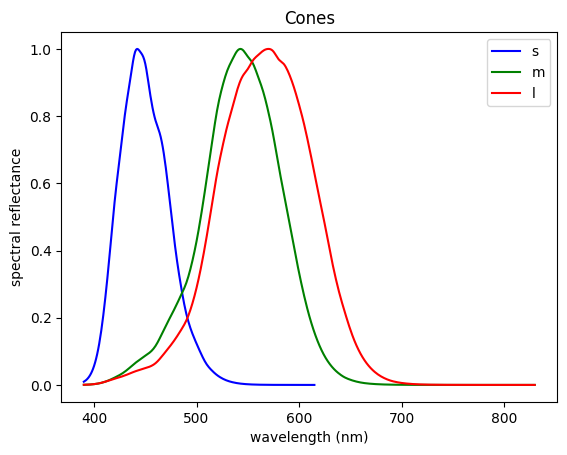

In [28]:
s_cone.plot(name="s", color="b")
m_cone.plot(name="m", color="g")
l_cone.plot(name="l", color="r")
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral reflectance')
plt.title('Cones')
plt.legend()
plt.show()

**Visualize Trichromat Gamut Space**

<IPython.core.display.Javascript object>


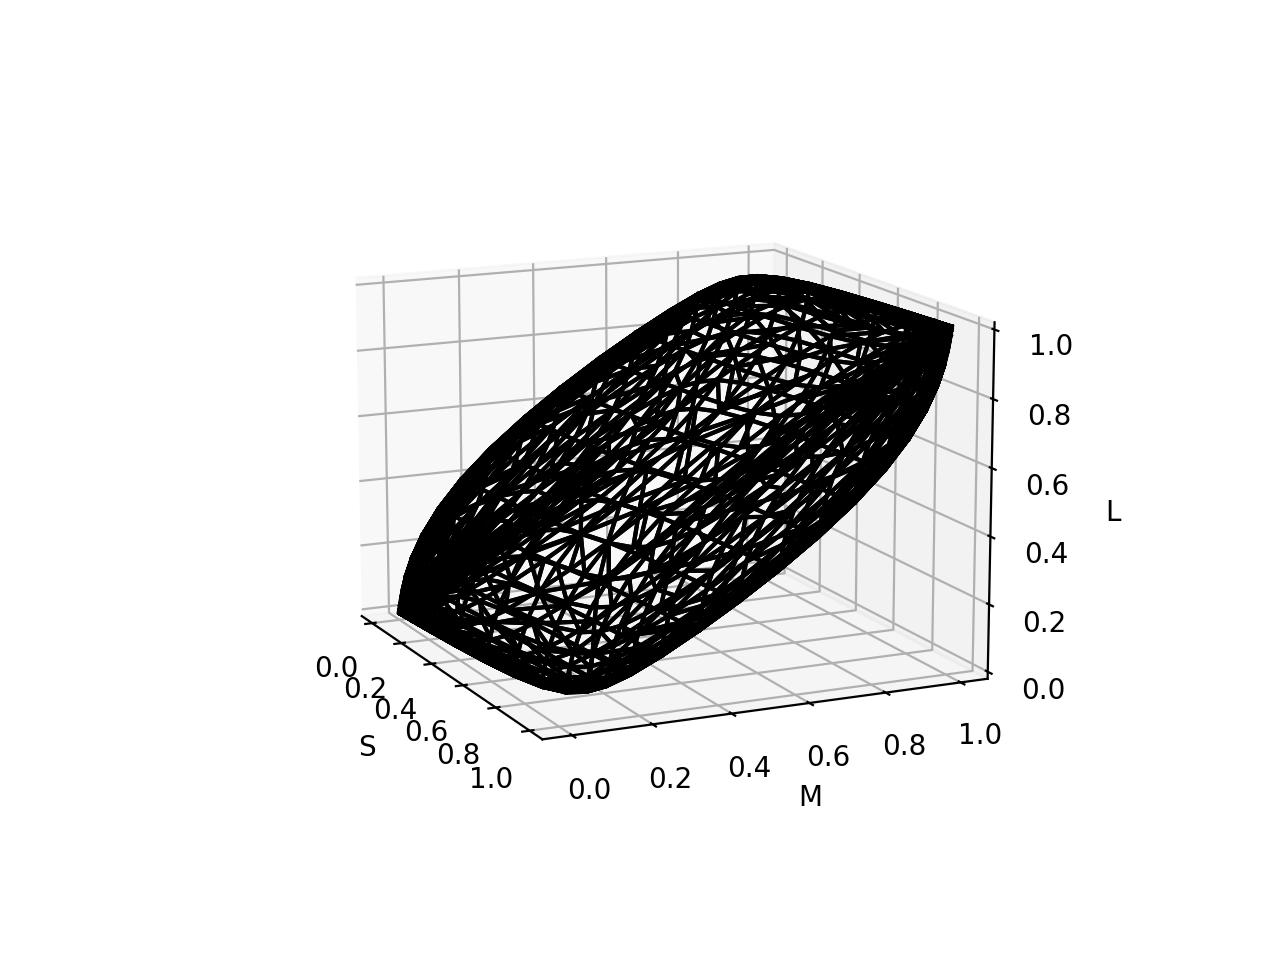

In [22]:
%matplotlib notebook

trichromat = Observer([s_cone, m_cone, l_cone], min_transition_size=10)
TRI_GAMUT_POINTS = trichromat.get_full_colors().T  # M x 3

hull = ConvexHull(TRI_GAMUT_POINTS)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel('S')
ax.set_ylabel('M')
ax.set_zlabel('L')


# Plot hull of the Gamut
for simplex in hull.simplices:
    s = simplex.astype(int)
    s = np.append(s, s[0]) 
    ax.plot(TRI_GAMUT_POINTS[s,0], TRI_GAMUT_POINTS[s,1], TRI_GAMUT_POINTS[s,2], "k-")

plt.show()

**Open3d Visualization**
This will visualize the full point cloud using open3d. May or may not work for you.

In [6]:
points = o3c.Tensor(TRI_GAMUT_POINTS)
pcd = o3d.t.geometry.PointCloud()

pcd.point.positions = points

hull = pcd.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull.to_legacy())
hull_ls.paint_uniform_color((1, 0, 0))


o3d.visualization.draw_geometries([hull.to_legacy(), pcd.to_legacy()])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


**Obtaining highly contrastive colors**

We want to obtain points $(s_1,m_1,l_1)$ and $(s_2, m_2, l_2)$ such that $(s_1, m_1)$ and $(s_2, m_2)$ are very close, and $l_1$ and $l_2$ are very far. We will make rays with starting points (x,y,0) with direction (0,0,1) and look for intersections.

In [23]:
def intersects_triangle(o, d, v0, v1, v2, eps=1e-6):
    e1 = v1 - v0
    e2 = v2 - v0
    
    h = np.cross(d, e2)
    
    a = np.dot(e1, h)
    
    # Check if ray is parallel to triangle
    if a > -eps and a < eps:
        return False, None
    
    f = 1.0 / a
    s = o - v0
    u = f * np.dot(s, h)
    
    if u < 0.0 or u > 1.0:
        return False, None
    
    q = np.cross(s, e1)
    v = f * np.dot(d, q)
    
    # Check for intersection
    if v < 0.0 or u + v > 1.0:
        return False, None
    
    t = f * np.dot(e2, q)
    
    if t > eps:
        return True, t
    else:
        return False, None


In [24]:
def intersects_hull(o, d, hull):
    intersection_indices = []
    
    for simplex in hull.simplices:
        vertices = [TRI_GAMUT_POINTS[idx] for idx in simplex]
        hit, t = intersects_triangle(o, d, *vertices)
        if hit:
            distances = [np.linalg.norm((o + t *d) - v) for v in vertices]
            # todo: could implement an interpolation approach
            
            closest_idx = np.argmin(distances)
            closest_vertex_idx = simplex[closest_idx]
            intersection_indices.append(closest_vertex_idx)
    return intersection_indices

In [25]:
o = np.array([0.4, 0.3, 0])
d = np.array([0,0,1])
a, b  = intersects_hull(o,d, hull)
print(np.linalg.norm(TRI_GAMUT_POINTS[a]-TRI_GAMUT_POINTS[b]))

print(np.linalg.norm(TRI_GAMUT_POINTS[a][:2]-TRI_GAMUT_POINTS[b][:2]))
for idx in intersects_hull(o,d, hull):
    print(TRI_GAMUT_POINTS[idx])

0.30778141219877564
0.06941232489946891
[0.32452638 0.3223535  0.18680254]
[0.35429925 0.25965065 0.48665471]


In [26]:
pairs = []
for o in np.array([[x, y, 0] for x in np.arange(0, 1.1, 0.1) for y in np.arange(0, 1.1, 0.1)]):
    intersections = intersects_hull(o, d, hull)
    if len(intersections) == 2:
        pairs.append(intersections)
print(len(pairs))

81


In [27]:
pairs[0]

[84881, 2209]

In [12]:
np.save("metamer_wavelengths", pairs)

In [41]:
dichromat = Observer([s_cone, m_cone], min_transition_size=10)

for (i,j) in pairs:
    col1 = dichromat.observe(trichromat.get_transition(i))
    col2 = dichromat.observe(trichromat.get_transition(j))
    print(col1, col2)

[0.08555052 0.09234071] [0.08857842 0.09771327]
[0.20058575 0.10126205] [0.19886991 0.09020008]
[0.17097925 0.17097368] [0.20995502 0.20300585]
[0.20949447 0.29907579] [0.18445613 0.26331533]
[0.31161982 0.21295702] [0.30164161 0.19531122]
[0.33622208 0.33302197] [0.31042438 0.2948158 ]
[0.29240578 0.39988653] [0.27348407 0.36070688]
[0.41667733 0.21422138] [0.37103767 0.1682693 ]
[0.40882472 0.2932059 ] [0.39717013 0.30529771]
[0.41493984 0.43785883] [0.3704431  0.38727116]
[0.4033661  0.47840482] [0.38619054 0.47194112]
[0.41234372 0.61480497] [0.37507147 0.55994626]
[0.51220536 0.31421905] [0.54201671 0.33924295]
[0.53661527 0.42913983] [0.48008145 0.40610844]
[0.49157953 0.48215016] [0.50842056 0.51784984]
[0.51991864 0.59389157] [0.46338482 0.57086018]
[0.48779472 0.68578096] [0.45798338 0.66075705]
[0.58765636 0.38519504] [0.62492841 0.44005373]
[0.61380954 0.52805889] [0.59663399 0.52159519]
[0.62955698 0.61272885] [0.58506024 0.56214117]
[0.60282995 0.6947023 ] [0.59117537 0.70

**Visualize visual eyes viz u a lies**

In [28]:
def index_to_rgb(index):
    transition = trichromat.get_transition(index)
    color = Spectra(wavelengths=trichromat.wavelengths, data=transition).to_rgb()

    return color 


<IPython.core.display.Javascript object>


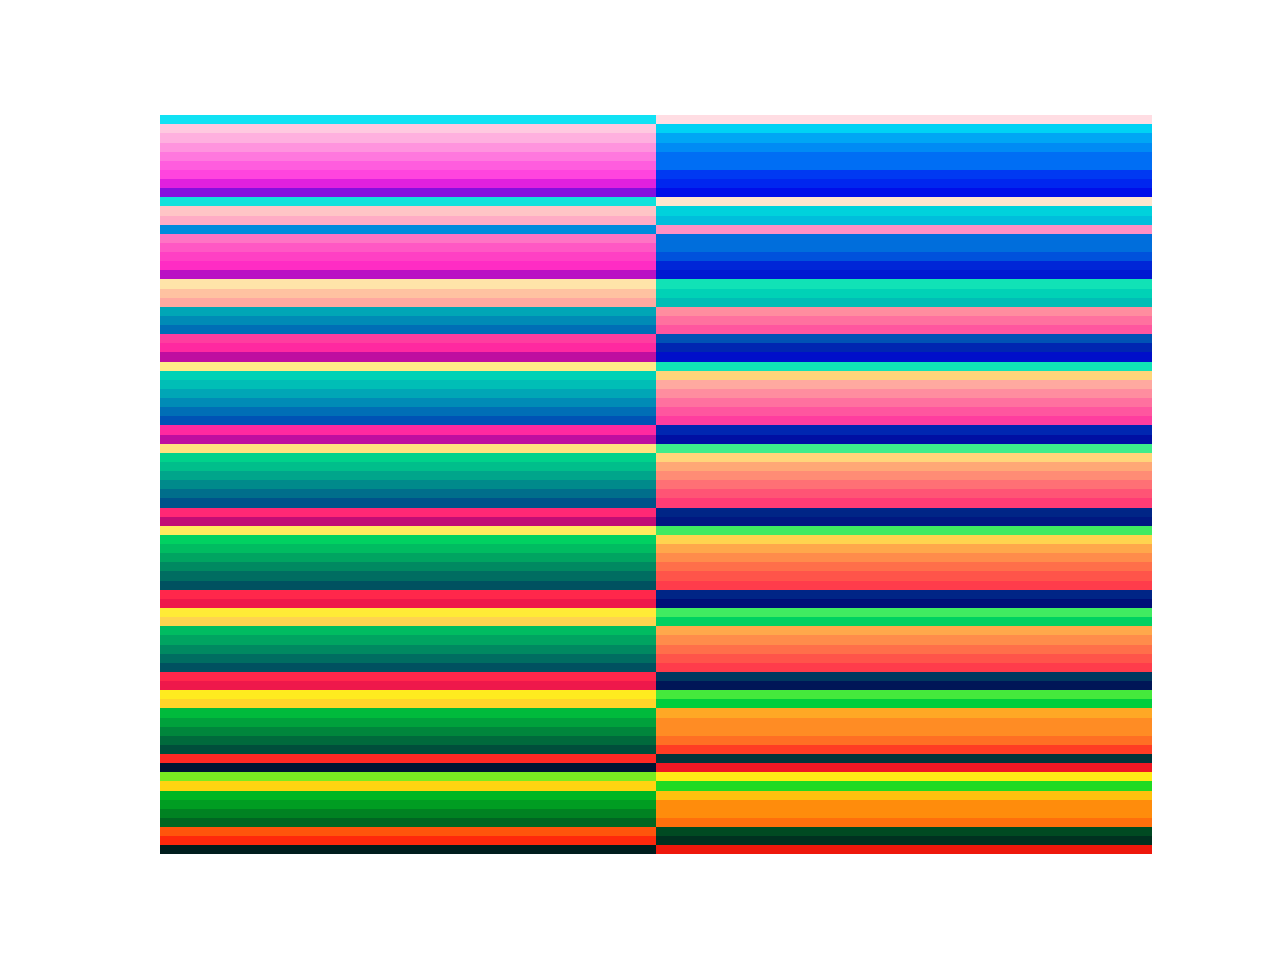

In [29]:
%matplotlib notebook

def show_confusions(pairs):
    fig, ax = plt.subplots()

    ax.set_xlim([0, 2])
    ax.set_ylim([0, len(pairs)])

    ax.axis('off')

    for i, (a,b) in enumerate(pairs):
        color_a = index_to_rgb(a).reshape(-1)
        color_b = index_to_rgb(b).reshape(-1)
    
        rect_a = plt.Rectangle((0, i), 1, 1, linewidth=1, edgecolor='none', facecolor=color_a)
        rect_b = plt.Rectangle((1, i), 1, 1, linewidth=1, edgecolor='none', facecolor=color_b)

        ax.add_patch(rect_a)
        ax.add_patch(rect_b)
    fig.savefig("metamers.png")
    plt.show()
    
show_confusions(pairs)

Above image is successful metamers, except the problem is a lot of the hull points are out of RGB Gamut so the visualization doesn't work.